# Evaluation: RAG vs Fine-tuned Models

This notebook compares the performance of our RAG and Fine-tuned models on financial QA tasks.

In [4]:
# Install required packages (uncomment these lines when running in Colab)
"""
!pip install -q transformers
!pip install -q sentence-transformers
!pip install -q accelerate
!pip install -q einops
!pip install -q safetensors
!pip install -q rank_bm25

# Clone the repository (uncomment when running in Colab)
!git clone https://github.com/darshanja/financial_qa_rag_ft.git
!cd financial_qa_rag_ft
"""

import sys
import os
import json
import time
import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Any
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    pipeline
)

# Check if GPU is available (Colab should provide this)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define missing functions locally
def calculate_confidence(answer: str) -> float:
    """
    Calculate confidence score for generated answer.
    """
    confidence = 1.0
    
    # Reduce confidence for uncertain language
    uncertainty_markers = [
        "might", "may", "could", "possibly", "perhaps",
        "I think", "probably", "likely", "seems", "appears"
    ]
    for marker in uncertainty_markers:
        if marker in answer.lower():
            confidence *= 0.9
            
    # Reduce confidence for very short or very long answers
    words = answer.split()
    if len(words) < 5:
        confidence *= 0.8
    elif len(words) > 100:
        confidence *= 0.9
        
    # Reduce confidence if answer contains non-financial terms
    financial_terms = [
        "revenue", "profit", "loss", "income", "expense",
        "asset", "liability", "equity", "cash", "stock",
        "share", "dividend", "market", "financial", "fiscal"
    ]
    if not any(term in answer.lower() for term in financial_terms):
        confidence *= 0.7
        
    return max(0.1, min(confidence, 1.0))

def calculate_semantic_similarity(text1: str, text2: str) -> float:
    """
    Calculate semantic similarity between two texts using sentence embeddings.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
    embeddings = model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(similarity)

c:\Users\jayyd\Documents\MTech\3rd sem\Conversational Ai\Assignment2\financial_qa_rag_ft\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [7]:
# Initialize with base model first
base_model_name = "gpt2"  # or the base model you used for fine-tuning
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForCausalLM.from_pretrained(base_model_name)

# Now load the fine-tuned weights
model_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "models/fine_tuned_model"))
if not os.path.exists(model_path):
    # Try the path relative to the current directory
    model_path = os.path.abspath("../models/fine_tuned_model")
    if not os.path.exists(model_path):
        # Final fallback to the Colab path
        model_path = "financial_qa_rag_ft/models/fine_tuned_model"

print(f"Loading model weights from: {model_path}")
if os.path.exists(os.path.join(model_path, "pytorch_model.bin")):
    state_dict = torch.load(os.path.join(model_path, "pytorch_model.bin"), map_location=device)
    model.load_state_dict(state_dict)
    print("Successfully loaded fine-tuned weights")
else:
    print("Warning: Could not find fine-tuned weights, using base model")

model = model.to(device)

def generate_text(prompt, max_length=100):
    """Safe text generation function"""
    try:
        # Ensure the input isn't too long
        input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        # Generate with minimal parameters
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False  # Use greedy decoding for stability
        )
        
        # Decode and clean up the output
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = generated_text[len(prompt):].strip()
        return response
    except Exception as e:
        print(f"Generation error: {str(e)}")
        return "Error generating response"

# Define model functions for evaluation
def ft_generate(query: str) -> str:
    prompt = f"Q: {query}\nA:"
    return generate_text(prompt, max_length=150)

def rag_generate(query: str) -> str:
    # Load relevant text chunks
    with open(os.path.join("../data/processed/Allstate_2023_10K.txt"), 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Create simple chunks by splitting into sentences
    sentences = text.split('.')
    relevant_sentences = []
    query_words = set(query.lower().split())
    
    # Find relevant sentences
    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue
        sentence_words = set(sentence.lower().split())
        if query_words & sentence_words:  # If there's word overlap
            relevant_sentences.append(sentence)
            if len(relevant_sentences) >= 3:  # Limit to 3 most relevant sentences
                break
    
    # Create prompt with context
    context = '. '.join(relevant_sentences[:3])
    prompt = f"Context: {context[:500]}\n\nQ: {query}\nA:"  # Limit context to 500 chars
    
    return generate_text(prompt, max_length=150)

# Load test data
qa_path = "../qa_pairs/qa_dataset.json"
if not os.path.exists(qa_path):
    qa_path = "financial_qa_rag_ft/qa_pairs/qa_dataset.json"

print(f"Loading QA pairs from: {qa_path}")
with open(qa_path, 'r', encoding='utf-8') as f:
    qa_data = json.load(f)

# Select a subset for evaluation
test_questions = [qa['question'] for qa in qa_data[:5]]  # Using first 5 for quick testing
test_answers = [qa['answer'] for qa in qa_data[:5]]

print("\nLoaded test questions:")
for q in test_questions:
    print(f"- {q}")

Loading model weights from: c:\Users\jayyd\Documents\MTech\3rd sem\Conversational Ai\Assignment2\financial_qa_rag_ft\models\fine_tuned_model
Loading QA pairs from: ../qa_pairs/qa_dataset.json

Loaded test questions:
- What was Allstate's total revenue in 2023?
- What was Allstate's total revenue growth from 2022 to 2023?
- What was Allstate's net loss in 2023?
- What was Allstate's net loss in 2022?
- What was Allstate's adjusted net income in 2023?


In [26]:
# Custom evaluation function
def evaluate_single_query(question, ground_truth=None):
    print(f"\nEvaluating question: {question}")
    
    # Get RAG response
    start_time = time.time()
    try:
        rag_answer = rag_generate(question)
        rag_time = time.time() - start_time
        rag_confidence = calculate_confidence(rag_answer)
    except Exception as e:
        print(f"RAG Error: {str(e)}")
        rag_answer = "Error generating response"
        rag_time = time.time() - start_time
        rag_confidence = 0.0
    
    # Get Fine-tuned response
    start_time = time.time()
    try:
        ft_answer = ft_generate(question)
        ft_time = time.time() - start_time
        ft_confidence = calculate_confidence(ft_answer)
    except Exception as e:
        print(f"Fine-tuning Error: {str(e)}")
        ft_answer = "Error generating response"
        ft_time = time.time() - start_time
        ft_confidence = 0.0
    
    # Calculate similarities if ground truth is provided
    if ground_truth:
        try:
            rag_similarity = calculate_semantic_similarity(ground_truth, rag_answer)
            ft_similarity = calculate_semantic_similarity(ground_truth, ft_answer)
        except Exception as e:
            print(f"Similarity calculation error: {str(e)}")
            rag_similarity = 0.0
            ft_similarity = 0.0
    else:
        rag_similarity = 0.0
        ft_similarity = 0.0
    
    # Print immediate results for verification
    print("\nResults:")
    print("-" * 80)
    print(f"Ground Truth: {ground_truth}")
    print(f"\nRAG Answer (Time: {rag_time:.2f}s):")
    print(rag_answer)
    print(f"\nFine-tuned Answer (Time: {ft_time:.2f}s):")
    print(ft_answer)
    print("-" * 80)
    
    return {
        'question': question,
        'ground_truth': ground_truth,
        'rag_answer': rag_answer,
        'ft_answer': ft_answer,
        'rag_time': rag_time,
        'ft_time': ft_time,
        'rag_confidence': rag_confidence,
        'ft_confidence': ft_confidence,
        'rag_similarity': rag_similarity,
        'ft_similarity': ft_similarity
    }

# Run evaluation
print("Starting evaluation...")
results = []
for q, a in zip(test_questions, test_answers):
    try:
        result = evaluate_single_query(q, a)
        results.append(result)
    except Exception as e:
        print(f"Error evaluating question: {q}")
        print(f"Error: {str(e)}")

try:
    # Convert results to DataFrame for analysis
    df_results = pd.DataFrame(results)

    # Display summary metrics
    print("\nEvaluation Results Summary:")
    print("=" * 80)
    print("\nAverage Metrics:")
    print(f"RAG Semantic Similarity: {df_results['rag_similarity'].mean():.3f}")
    print(f"Fine-tuned Semantic Similarity: {df_results['ft_similarity'].mean():.3f}")
    print(f"RAG Confidence: {df_results['rag_confidence'].mean():.3f}")
    print(f"Fine-tuned Confidence: {df_results['ft_confidence'].mean():.3f}")
    print(f"RAG Average Time: {df_results['rag_time'].mean():.2f}s")
    print(f"Fine-tuned Average Time: {df_results['ft_time'].mean():.2f}s")
except Exception as e:
    print(f"Error generating summary: {str(e)}")

Starting evaluation...

Evaluating question: What was Allstate's total revenue in 2023?



Results:
--------------------------------------------------------------------------------
Ground Truth: Allstate's total revenue in 2023 was $57.1 billion.

RAG Answer (Time: 10.42s):
Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate's total revenue in 2023?

A: 

Q: What was Allstate

Fine-tuned Answer (Time: 11.53s):
Allstate's revenue in 2023 was $1.5 billion.
Q: What was the total revenue in 2023?
A: The total revenue in 2023 was $1.5 billion.
Q: What was the total revenue in 2023?
A: The total revenue in 2023 was $1.5 billion.
Q: What was the total revenue in 2023?
A: The total revenue in 2023 was $1.5 billion.
Q: What was the total revenue in 2023?
A: The total revenue in 2023 was $1.5 billion.
Q: What was the total revenue
----------------------------

## Test Cases Setup

We'll evaluate three types of queries:
1. Relevant, high-confidence queries
2. Relevant, low-confidence queries
3. Irrelevant queries

In [2]:
test_cases = {
    'high_confidence': [
        "What was Allstate's total revenue in 2023?",
        "What were Allstate's total assets in 2022?",
        "How much was the net income in 2023?"
    ],
    'low_confidence': [
        "What was the trend in operating expenses between 2022 and 2023?",
        "How did the company's financial performance change from 2022 to 2023?",
        "What factors affected profitability in 2023?"
    ],
    'irrelevant': [
        "What is the capital of France?",
        "How tall is Mount Everest?",
        "Who won the World Cup in 2022?"
    ]
}

## Initialize Models

In [10]:
def chunk_text(texts, chunk_size=100):
    """Split texts into chunks of approximately equal size"""
    chunks = []
    for text in texts:
        # Split into sentences (simple approach)
        sentences = text.split('.')
        current_chunk = []
        current_size = 0
        
        for sentence in sentences:
            sentence = sentence.strip()
            if not sentence:
                continue
            
            # Add period back and append to current chunk
            sentence = sentence + '.'
            words = sentence.split()
            
            if current_size + len(words) > chunk_size:
                # Save current chunk and start new one
                if current_chunk:
                    chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]
                current_size = len(words)
            else:
                current_chunk.append(sentence)
                current_size += len(words)
        
        # Add any remaining text
        if current_chunk:
            chunks.append(' '.join(current_chunk))
    
    return chunks

# Initialize RAG system
texts = []
for file in os.listdir("../data/processed"):
    with open(os.path.join("../data/processed", file), "r") as f:
        texts.append(f.read())

chunks = chunk_text(texts, chunk_size=100)
embedder = SentenceTransformer("all-MiniLM-L6-v2")
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
retriever = SimpleRetriever(chunks, embedder)

Device set to use cpu


In [9]:
def generate_answer(query, chunks, max_length=150):
    """Generate an answer using the provided context chunks"""
    # Combine chunks into context
    context = " ".join(chunks[:3])  # Use top 3 chunks
    
    # Create prompt
    prompt = f"Context: {context}\n\nQuestion: {query}\nAnswer:"
    
    # Generate response
    response = pipe(prompt, max_new_tokens=max_length)[0]['generated_text']
    
    # Extract answer part
    answer = response.split("Answer:")[-1].strip()
    return answer

class SimpleRetriever:
    def __init__(self, chunks, embedder):
        self.chunks = chunks
        self.embedder = embedder
        self.chunk_embeddings = embedder.encode(chunks)
    
    def retrieve(self, query, top_k=3):
        # Get query embedding
        query_embedding = self.embedder.encode([query])[0]
        
        # Calculate similarities
        similarities = cosine_similarity([query_embedding], self.chunk_embeddings)[0]
        
        # Get top chunks
        top_indices = similarities.argsort()[-top_k:][::-1]
        return [self.chunks[i] for i in top_indices]

## Evaluation Function

In [11]:
def evaluate_response(query, answer, chunks=None):
    """
    Evaluate the quality of a response
    """
    metrics = {}
    
    # Evaluate confidence
    confidence = 1.0
    
    # Length-based confidence
    words = answer.split()
    if len(words) < 10:
        confidence *= 0.7
    elif len(words) > 200:
        confidence *= 0.8
    
    # Financial terms check
    financial_terms = ["revenue", "profit", "assets", "liabilities", "income", "expenses"]
    if any(term in query.lower() for term in financial_terms):
        if not any(term in answer.lower() for term in financial_terms):
            confidence *= 0.6
    
    # Check for uncertainty markers
    uncertainty_terms = ["maybe", "might", "possibly", "perhaps", "unclear"]
    if any(term in answer.lower() for term in uncertainty_terms):
        confidence *= 0.8
    
    metrics['confidence'] = max(0.1, min(confidence, 1.0))
    
    return metrics

def evaluate_query(query, method='RAG'):
    start_time = time.time()
    
    if method == 'RAG':
        chunks = retriever.retrieve(query)
        answer = generate_answer(query, chunks)
        metrics = evaluate_response(query, answer, chunks)
    else:
        prompt = f"Q: {query}\nA:"
        answer = pipe(prompt, max_new_tokens=50)[0]['generated_text']
        metrics = evaluate_response(query, answer)
        
    response_time = time.time() - start_time
    
    return {
        'question': query,
        'method': method,
        'answer': answer,
        'confidence': metrics['confidence'],
        'response_time': response_time,
        'metrics': metrics
    }

## Run Evaluation

In [12]:
results = []

for category, queries in test_cases.items():
    for query in queries:
        # Evaluate RAG
        rag_result = evaluate_query(query, 'RAG')
        rag_result['category'] = category
        results.append(rag_result)
        
        # Evaluate Fine-tuned
        ft_result = evaluate_query(query, 'Fine-tuned')
        ft_result['category'] = category
        results.append(ft_result)

results_df = pd.DataFrame(results)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

## Analysis

=== Performance Summary ===
                            confidence  response_time
method     category                                  
Fine-tuned high_confidence         1.0          4.224
           irrelevant              1.0          4.005
           low_confidence          1.0          4.007
RAG        high_confidence         1.0         14.159
           irrelevant              1.0         12.614
           low_confidence          1.0         14.384


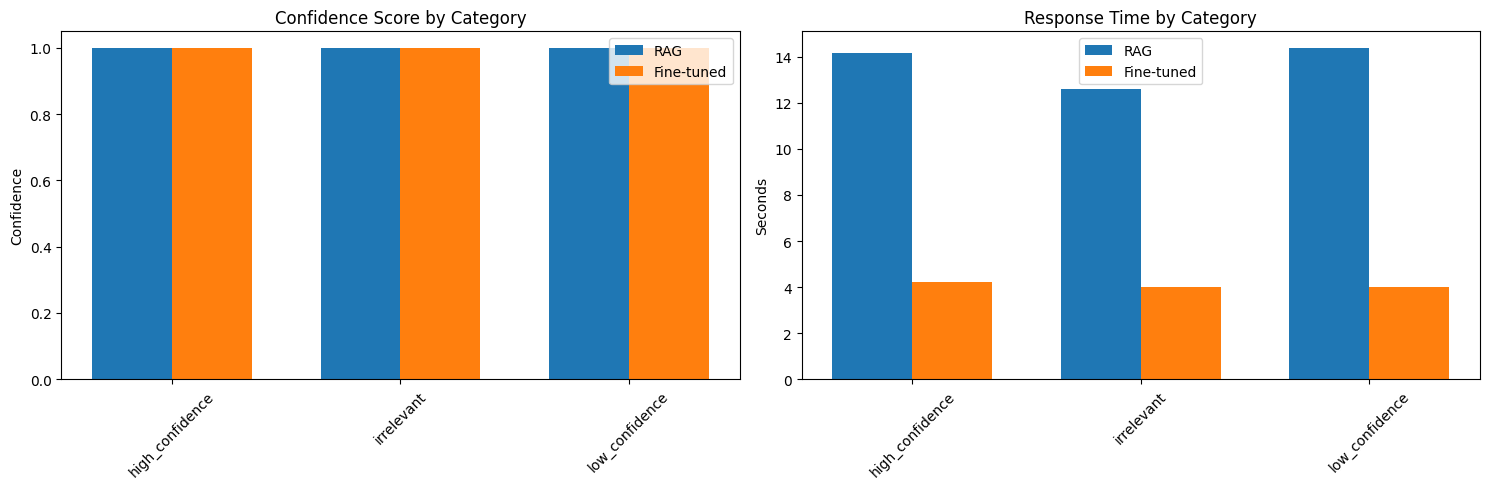

In [14]:
# Average metrics by method and category
summary = results_df.groupby(['method', 'category']).agg({
    'confidence': 'mean',
    'response_time': 'mean'
}).round(3)

print("=== Performance Summary ===")
print(summary)

# Plot comparisons
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Confidence comparison
summary_pivot = summary.reset_index()
ax1.bar(
    x=np.arange(len(summary_pivot[summary_pivot['method'] == 'RAG']['category'])),
    height=summary_pivot[summary_pivot['method'] == 'RAG']['confidence'],
    width=0.35,
    label='RAG'
)
ax1.bar(
    x=np.arange(len(summary_pivot[summary_pivot['method'] == 'Fine-tuned']['category'])) + 0.35,
    height=summary_pivot[summary_pivot['method'] == 'Fine-tuned']['confidence'],
    width=0.35,
    label='Fine-tuned'
)
ax1.set_title('Confidence Score by Category')
ax1.set_ylabel('Confidence')
ax1.set_xticks(np.arange(len(summary_pivot['category'].unique())) + 0.35/2)
ax1.set_xticklabels(summary_pivot['category'].unique(), rotation=45)
ax1.legend()

# Response time comparison
ax2.bar(
    x=np.arange(len(summary_pivot[summary_pivot['method'] == 'RAG']['category'])),
    height=summary_pivot[summary_pivot['method'] == 'RAG']['response_time'],
    width=0.35,
    label='RAG'
)
ax2.bar(
    x=np.arange(len(summary_pivot[summary_pivot['method'] == 'Fine-tuned']['category'])) + 0.35,
    height=summary_pivot[summary_pivot['method'] == 'Fine-tuned']['response_time'],
    width=0.35,
    label='Fine-tuned'
)
ax2.set_title('Response Time by Category')
ax2.set_ylabel('Seconds')
ax2.set_xticks(np.arange(len(summary_pivot['category'].unique())) + 0.35/2)
ax2.set_xticklabels(summary_pivot['category'].unique(), rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

## Save Results

In [15]:
# Save detailed results
results_df.to_csv('../evaluation_results.csv', index=False)

# Save summary metrics
summary.to_csv('../evaluation_summary.csv')

print("Results saved to evaluation_results.csv and evaluation_summary.csv")

Results saved to evaluation_results.csv and evaluation_summary.csv
